<a href="https://colab.research.google.com/github/BStar14/Classical-Quantum_Hybird_CNN/blob/main/Boseong%20Kim/05_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd/content/gdrive/MyDrive/Colab Notebooks/QHK2021/05_test

/content/gdrive/MyDrive/Colab Notebooks/QHK2021/05_test


In [ ]:
!pip install pennylane --upgrade

In [ ]:
!pip install qiskit ipywidgets

In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import matplotlib.pyplot as plt
from qiskit import *
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler

import numpy.random as random
import pandas as pd
# import time

In [6]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [7]:
n_epochs = 100        # Number of optimization epochs
n_channels = 1        # Number of channels
n_train = 1280        # Size of the train dataset
n_test = 320          # Size of the test dataset
learning_rate = 5e-3  # Learning rate
BATCH_SIZE = 16       # Size of batch

SAVE_PATH = "quanvolution_pqc/"   # Data saving folder
PREPROCESS = True                 # If False, skip quantum processing and load data from SAVE_PATH
random.seed(0)                    # Seed for NumPy random number generator

n_poly = 4                  # Order of polynomials (Highest order)
n_kernel = 3**2             # Size of kernel

rand_params = random.default_rng()
rand_params = 1 - rand_params.standard_normal(size=(n_channels, n_poly, n_kernel))

In [8]:
train_dataset = datasets.MNIST(root = "./",
                               train = True,
                               download = True,
                               transform=transforms.Compose([
                                  transforms.Resize(size=14),
                                  transforms.ToTensor()
                                ]))

test_dataset = datasets.MNIST(root = "./",
                              train = False,
                              download = False,
                              transform=transforms.Compose([
                                transforms.Resize(size=14),
                                transforms.ToTensor()
                              ]))

train_sampler = SubsetRandomSampler(range(n_train))
test_sampler = SubsetRandomSampler(range(n_test))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,
                                           sampler = train_sampler)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False,
                                          sampler = test_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
token1 = '2b740fada862fb6d9683487f84455ff8fccb2caaa3988e4f406d321ef67ce0644eb679211a1b6a377ec5ee9b3839d34434255304ab535a9ed11ce60703f07446'
token2 = '08952555d263c29c9b015855d49bcbf0e7a3cb1354b5520743285bb48d19f0db420522be05c80dd1fb19179c42d798b238ae7b944568bb6e7e7284d9bfeb0209'

# from qiskit import IBMQ
# IBMQ.save_account(token2)
# provider = IBMQ.enable_account(token1)
dev = qml.device("default.qubit", wires=9)
# dev = qml.device('qiskit.ibmq', wires=9, backend='ibmq_qasm_simulator',provider=provider)
# IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# dev = qml.device('qiskit.ibmq', wires=9, backend='ibmq_qasm_simulator',
                #  ibmqx_token=token1, hub='ibm-q', group='open', project='main')
# print(dev.capabilities()['backend'])
# import pennylane as qml
# from pennylane_ionq import ops

# dev = qml.device("ionq.qpu", wires=9)

# Random circuit parameters

@qml.qnode(dev, interface='torch')
def pqc(data,params):
    # Encoding of 9 classical input values
    # len(params) = 2 * 9
    # print("data: ",data)
    # print("params: ",params)
    n_qubits = 9
    for j in range(n_qubits):
        qml.RY(np.pi * data[j], wires=j)
    
    # rand_params = np.random.uniform(high=2 * np.pi, size=(n_channels, 9))
    # print("rand", rand_params)
    # PQC
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])    
    qml.CNOT(wires=[n_qubits-1,0])
    for i in range(n_qubits):
        qml.RY(params[i+n_qubits], wires=i)
    # Measurement producing 9 classical output values
    return qml.expval(qml.PauliZ(0))

In [10]:
print(pqc([1,0,2,1,2,3,1,2,0],[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]))

tensor(0.5919, dtype=torch.float64)


In [11]:
class QuanvNet(torch.nn.Module):
    def __init__(self, qc=True, opt=True):
        super().__init__()
        self.qc = qc
        self.opt = opt
        self.n_qubits = 9
        self.filters = n_channels
        self.conv_opt = torch.nn.Conv2d(in_channels=self.filters,out_channels=self.filters,kernel_size=3)
        self.conv1 = torch.nn.Conv2d(in_channels=self.filters,out_channels=8,kernel_size=3,padding='same')
        self.pre_pool = torch.nn.AvgPool2d(2)
        self.pool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(in_channels=8,out_channels=8,kernel_size=3)
        self.fc1 = torch.nn.Linear(32,16)
        self.fc2 = torch.nn.Linear(16,10)
        self.dropout = torch.nn.Dropout(0.4)
        self.q_params = torch.nn.Parameter(2*np.pi*torch.rand(12,12,self.filters,2*self.n_qubits))
        self.q_params.requires_grad = True

    def forward(self, inputs):
        if self.qc == True:
          out = torch.zeros((BATCH_SIZE,self.filters,12,12))
          for bat, image in enumerate(inputs):
              for j in range(1, 13, 1):
                  for k in range(1, 13, 1):
                      for i in range(self.filters):
                          q_results = pqc(
                          [
                              image[0, j - 1, k - 1].item(),
                              image[0, j - 1, k].item(),
                              image[0, j - 1, k + 1].item(),
                              image[0, j, k - 1].item(),
                              image[0, j, k].item(),
                              image[0, j, k + 1].item(),
                              image[0, j + 1, k - 1].item(),
                              image[0, j + 1, k].item(),
                              image[0, j + 1, k + 1].item()
                          ],
                              self.q_params[j-1,k-1,i]
                          )
                          out[bat,i,j - 1, k - 1] = q_results
        else:
          out = torch.zeros((BATCH_SIZE,self.filters,14,14))
          out = inputs
        print(out.size())
        if use_cuda:
          out = out.cuda()
        if self.opt==True:
          out = self.conv_opt(inputs)
        x = self.pool(F.relu(self.conv1(out)))
        print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        print(x.size())
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x))
        return x


In [12]:
## Random Polynomial Definition
def rand_poly(x_kernel):

  result = .0               # result will be numpy.float
  
  # runs on order and input kernel
  for j in range(n_poly):
    for k, x in enumerate(x_kernel):
      # polynomial centered (.5, .5)
      result = result + rand_params[0, j, k] * ((2 * (x - .5)) ** (j + 1)) / 2 + .5

  return result

In [13]:
class NLNet(torch.nn.Module):
    def __init__(self, nl=True, opt=False):
        super().__init__()
        self.nl = nl
        self.opt = opt
        self.filters = n_channels
        self.conv_opt = torch.nn.Conv2d(in_channels=self.filters,out_channels=self.filters,kernel_size=3)
        self.conv1 = torch.nn.Conv2d(in_channels=self.filters,out_channels=8,kernel_size=3,padding='same')
        self.pre_pool = torch.nn.AvgPool2d(2)
        self.pool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(in_channels=8,out_channels=8,kernel_size=3)
        self.fc1 = torch.nn.Linear(32,16)
        self.fc2 = torch.nn.Linear(16,10)
        self.dropout = torch.nn.Dropout(0.4)

    def forward(self, inputs, **kwargs):
        if self.nl == True:
          out = torch.zeros((BATCH_SIZE,self.filters,12,12))
          for bat, image in enumerate(inputs):
              for j in range(1, 13, 1):
                  for k in range(1, 13, 1):
                      nl_results = rand_poly(
                      [
                          image[0, j - 1, k - 1].item(),
                          image[0, j - 1, k].item(),
                          image[0, j - 1, k + 1].item(),
                          image[0, j, k - 1].item(),
                          image[0, j, k].item(),
                          image[0, j, k + 1].item(),
                          image[0, j + 1, k - 1].item(),
                          image[0, j + 1, k].item(),
                          image[0, j + 1, k + 1].item()
                      ]
                      )
                      out[bat,0,j - 1, k - 1] = nl_results
          # if check_plot == 0:
          #   pltsize = 1
          #   plt.figure(figsize=(BATCH_SIZE * pltsize, n_channels * pltsize))
          #   for i in range(BATCH_SIZE):
          #     for j in range(0, n_channels, 3):
          #       plt.subplot((n_channels+2)/3, BATCH_SIZE, i + j*BATCH_SIZE/3 + 1)
          #       plt.axis('off')
          #       plt.imshow(out[i, j, :, :].reshape(12, 12), cmap = "gray_r")

        else:
          out = torch.zeros((BATCH_SIZE,self.filters,14,14))
          out = inputs
        # print(out.size())
        if use_cuda:
          out = out.cuda()
        if self.opt==True:
          out = self.conv_opt(inputs)
        x = self.pool(F.relu(self.conv1(out)))
        # print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x))
        return x


In [14]:
from torchsummary import summary
criterion = torch.nn.CrossEntropyLoss()
# model = QuanvNet(qc=True, opt=False)
model = NLNet(nl=True, opt=False)
if use_cuda:
    model.cuda()
opt = optim.Adam(model.parameters(),lr=learning_rate)
summary(model,(1,14,14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]              80
         MaxPool2d-2              [-1, 8, 6, 6]               0
            Conv2d-3              [-1, 8, 4, 4]             584
         MaxPool2d-4              [-1, 8, 2, 2]               0
            Linear-5                   [-1, 16]             528
           Dropout-6                   [-1, 16]               0
            Linear-7                   [-1, 10]             170
Total params: 1,362
Trainable params: 1,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [15]:
for p in model.parameters():
    print(p.shape)

torch.Size([1, 1, 3, 3])
torch.Size([1])
torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([16, 32])
torch.Size([16])
torch.Size([10, 16])
torch.Size([10])


In [17]:
losses = []
accs = []

for epoch in range(n_epochs):
  train_loss = 0
  acc = 0  
  for (x_train, y_train) in train_loader:

    # if check_plot == 0:
    #   pltsize = 1
    #   plt.figure(figsize=(BATCH_SIZE * pltsize, pltsize))
    #   for i in range(BATCH_SIZE):
    #     plt.subplot(1, BATCH_SIZE, i + 1)
    #     plt.axis('off')
    #     plt.imshow(x_train[i, :, :, :].numpy().reshape(14, 14), cmap = "gray_r")
    #     plt.title('Class: ' + str(y_train[i].item()))

    # print(y_train)
    opt.zero_grad()
    outputs = model(x_train.cuda() if use_cuda else x_train)
    _, preds = torch.max(outputs,1)
    acc += (preds==(y_train.cuda() if use_cuda else y_train)).sum().item()
    loss = criterion(outputs,(y_train.cuda() if use_cuda else y_train))
    loss.backward()
    opt.step()
    train_loss += loss
    del loss
  
  acc /= n_train
  train_loss /= (n_train/BATCH_SIZE)

  losses.append(train_loss.item())
  accs.append(acc)
  print(f'epoch: {epoch+1}, acc: {acc}, loss: {train_loss}')
  
  del acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1, acc: 0.128125, loss: 2.299448013305664
2, acc: 0.12890625, loss: 2.297483444213867
3, acc: 0.1078125, loss: 2.2969579696655273
4, acc: 0.12578125, loss: 2.297328472137451
5, acc: 0.13046875, loss: 2.2940518856048584
6, acc: 0.13046875, loss: 2.2968945503234863
7, acc: 0.14609375, loss: 2.2900915145874023
8, acc: 0.15625, loss: 2.2817952632904053


KeyboardInterrupt: ignored

In [ ]:
file_name = ''
file = pd.DataFrame(data={'train_loss': losses,
                          'train_acc': accs})
file.to_pickle(file_name)

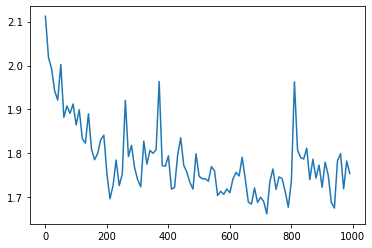

In [61]:
from matplotlib.pyplot import plot
x = np.arange(0,1000,10)
plot(x,losses)

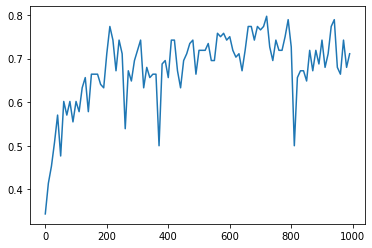

In [62]:
x = np.arange(0,1000,10)
plot(x,accs)